# Projet : Extraction et Recommandation de films et séries avec rdflib et SPARQL

## Objectif
L’objectif de ce mini-projet est l’extraction des données de la base de données DBPedia en utilisant le langage de requêtes SPARQL afin d'alimenter la base de données de séries que vous avez créé au premier TP, l’analyse de ces données et la recommandation de séries et de films.

# Description

Vous allez créer un système de recommandation de séries/films basé sur des données RDF qui stockent des informations sur les films, les utilisateurs et leurs préférences cinématographiques.

Les étapes du projet sont comme suit :

## 1.  Extraction des données

a)  Vous utiliserez Rdflib pour accéder aux données et vous effectuerez des requêtes SPARQL pour les extraire. Vous êtes libres dans le choix et la taille des données que vous allez extraire. Le jeu de données doit néanmoins être représentatif pour pouvoir fournir des recommandations précises. 
    
   - Les données à extraire : 
       - Films : Chaque film a un titre, un réalisateur, une année de sortie, un genre (e.g. : action, comédie, science-fiction), un résumé, une liste d'acteurs principaux, une durée, une évaluation du film, etc.
       - Réalisateur : Chaque réalisateur a un nom, une biographie et une liste de films qu'il a réalisés.
       - Acteurs : Chaque acteur a un nom, une biographie et une liste de films dans lesquels il a joué.
       - Genres :  Chaque genre a un nom et une description.
       - Utilisateurs : chaque utilisateur a un identifiant et des préférences cinématographiques (acteurs préférés, genres préférés, etc).
       - Évaluations : Elle est décrite par l'identifiant de l'utilisateur qui a donné l'évaluation, identifiant du film évalué la note attribuée au film, Commentaire ou avis sur le film.

   - Liens entre les entités : 

        - Les films sont associés à leurs acteurs, réalisateurs et genres.
        - Les utilisateurs sont associés aux films qu'ils ont évalués.
        - Les utilisateurs peuvent être liés entre eux en fonction de leurs préférences cinématographiques similaires.

   b)  Transformer les données en triplets RDF :  Vous allez transformer ces résultats en triplets RDF avant de les ajouter à votre graphe RDF existant. 
  
  c) Ajouter les données au graphe existant : Utilisez la méthode g.add() de votre graphe RDF, que vous avez créé au premier TP, pour ajouter les triplets RDF représentant les données DBpedia que vous avez transformées. 

Graph saved to graph_data.ttl

Top Content-Based Recommendations:

Film: http://dbpedia.org/resource/Cabin_by_the_Lake
  Similarity Score: 0.761
  Top Overlapping Tokens: ['lake', 'cabin', 'stanley', 'movie', 'film']

Film: http://dbpedia.org/resource/Cadet_Kelly
  Similarity Score: 0.694
  Top Overlapping Tokens: ['kelly', 'duff', 'cadet', 'film', 'http']

Film: http://dbpedia.org/resource/Calvento_Files
  Similarity Score: 0.201
  Top Overlapping Tokens: ['org', 'resource', 'http', 'dbpedia', 'channel']

Film: http://dbpedia.org/resource/Power_Rangers_Mystic_Force
  Similarity Score: 0.188
  Top Overlapping Tokens: ['resource', 'org', 'http', 'dbpedia', 'disney']

Film: http://dbpedia.org/resource/Carrie_(2002_film)
  Similarity Score: 0.188
  Top Overlapping Tokens: ['film', 'horror', '2002', 'org', 'resource']

Recommendations saved to recommendations.txt


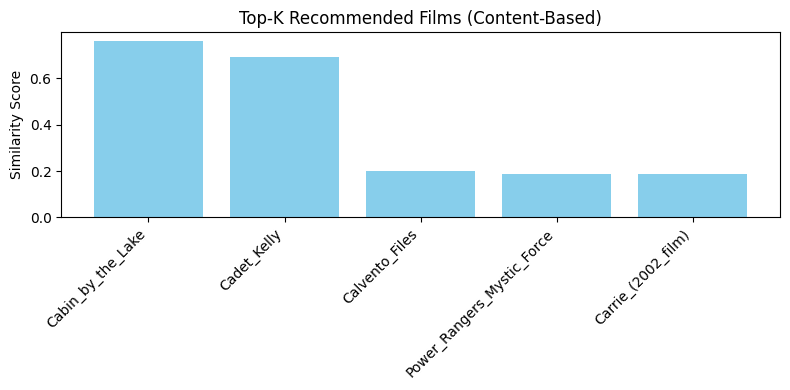

Evaluation Scores: {'MAP@k': 1.0, 'NDCG@k': np.float64(1.0)}


In [2]:
import rdflib
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

# ------------------------- 1. EXTRACT & BUILD GRAPH -------------------------
EX = Namespace("http://example.org/film#")

def extract_data_sparql():
    """
    Example: Extract film data from DBpedia.
    Adjust the SPARQL query to include more fields if desired.
    """
    endpoint = "http://dbpedia.org/sparql"
    query = """
    SELECT ?film ?title ?director ?genre ?abstract
    WHERE {
       ?film rdf:type dbo:Film ;
             rdfs:label ?title ;
             dbo:director ?director ;
             dbo:genre ?genre ;
             dbo:abstract ?abstract .
       FILTER (lang(?title) = 'en')
       FILTER (lang(?abstract) = 'en')
    }
    LIMIT 100
    """
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results["results"]["bindings"]

def build_rdf_graph(data):
    """
    Convert SPARQL JSON results into RDF triples and add them to a graph.
    """
    g = Graph()
    g.bind("ex", EX)

    for row in data:
        film_uri = URIRef(row["film"]["value"])
        g.add((film_uri, RDF.type, EX.Film))

        # Title
        if "title" in row:
            title = row["title"]["value"]
            g.add((film_uri, RDFS.label, Literal(title)))

        # Director
        if "director" in row:
            director_uri = URIRef(row["director"]["value"])
            g.add((film_uri, EX.director, director_uri))

        # Genre
        if "genre" in row:
            genre_uri = URIRef(row["genre"]["value"])
            g.add((film_uri, EX.genre, genre_uri))

        # Summary/abstract
        if "abstract" in row:
            summary = row["abstract"]["value"]
            g.add((film_uri, EX.summary, Literal(summary)))

    return g

# ------------------------- 2. PREPROCESSING -------------------------
def preprocess_data(g):
    """
    Remove duplicates, handle missing values, and normalize text to lowercase.
    """
    cleaned_graph = rdflib.Graph()
    for s, p, o in g:
        if isinstance(o, Literal):
            text = o.strip()
            if text:  # skip empty strings
                cleaned_graph.add((s, p, Literal(text.lower())))
        else:
            cleaned_graph.add((s, p, o))
    return cleaned_graph

# ------------------------- 3. EXPLORATORY ANALYSIS (Example) -------------------------
def analyze_data(g):
    """
    Simple distribution chart for genres.
    """
    genres = []
    for s, p, o in g.triples((None, EX.genre, None)):
        genres.append(str(o))

    if genres:
        genre_counts = Counter(genres)
        labels, values = zip(*genre_counts.items())
        plt.figure(figsize=(8, 4))
        plt.bar(labels, values)
        plt.title("Genre Distribution")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("No genres found in graph.")

# ------------------------- 4. CONTENT-BASED RECOMMENDATION -------------------------
def build_film_descriptions(graph):
    """
    For each film, combine label, directors, genres, summary, etc. into text.
    """
    film_descriptions = {}
    for film in graph.subjects(RDF.type, EX.Film):
        title = next(graph.objects(film, RDFS.label), "")
        directors = " ".join(str(d) for d in graph.objects(film, EX.director))
        genres = " ".join(str(g) for g in graph.objects(film, EX.genre))
        summary = next(graph.objects(film, EX.summary), "")

        combined_text = f"{title} {directors} {genres} {summary}"
        film_descriptions[film] = combined_text.lower().strip()

    return film_descriptions

def generate_user_profile(graph, user_prefs):
    """
    Turn the user's preferences into a single text 'profile':
      - genres, directors, actors
      - summaries from favorite films
    """
    pref_genres = " ".join(user_prefs.get("genres", []))
    pref_directors = " ".join(user_prefs.get("directors", []))
    pref_actors = " ".join(user_prefs.get("actors", []))

    user_profile_text = f"{pref_genres} {pref_directors} {pref_actors}"

    # Optionally include details from user's favorite films
    film_descriptions = build_film_descriptions(graph)
    for fav_film_uri in user_prefs.get("favorite_films", []):
        fav_film_ref = URIRef(fav_film_uri)
        if fav_film_ref in film_descriptions:
            user_profile_text += " " + film_descriptions[fav_film_ref]

    return user_profile_text.lower().strip()

def content_based_recommendation(graph, user_prefs, top_k=5):
    """
    1) Build textual descriptions for each film.
    2) Generate a single textual 'profile' for the user.
    3) Compare (TF-IDF) the user profile vector to each film's vector.
    4) Return the top_k film URIs, plus an explanation of 'why' for each.
    """
    # Step A: Build the descriptions
    film_data = build_film_descriptions(graph)
    if not film_data:
        print("No film data available for recommendation.")
        return [], []

    # Step B: Build the user profile
    user_profile_text = generate_user_profile(graph, user_prefs)
    if not user_profile_text:
        print("User has no preferences/favorite films specified.")
        return [], []

    # Step C: Vectorize
    #   docs[0] = user profile
    #   docs[1..end] = film descriptions
    docs = [user_profile_text] + list(film_data.values())
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(docs)

    user_vec = tfidf_matrix[0:1]     # user profile is row 0
    film_vectors = tfidf_matrix[1:]  # films are rows 1..end
    similarities = cosine_similarity(user_vec, film_vectors).flatten()

    # Step D: Sort & get top_k
    top_indices = similarities.argsort()[::-1][:top_k]
    film_uris = list(film_data.keys())
    recommendations = [film_uris[i] for i in top_indices]
    scores = [similarities[i] for i in top_indices]

    # Step E: Explanation (optional)
    #   We'll show top tokens that contributed to similarity for each recommended film.
    #   This is a simple approach: find the tokens that have high TF-IDF in both user & film doc.
    feature_names = tfidf.get_feature_names_out()
    explanations = []
    for i in top_indices:
        film_vec = film_vectors[i]
        # Dot product with user vector to find overlapping tokens
        overlap = user_vec.multiply(film_vec)
        # Extract top tokens (by TF-IDF weight) in the overlap
        overlap_array = overlap.toarray()[0]
        top_token_indices = overlap_array.argsort()[::-1][:5]  # top 5 tokens
        top_tokens = [feature_names[idx] for idx in top_token_indices if overlap_array[idx] > 0]
        explanations.append(top_tokens)

    return list(zip(recommendations, scores, explanations)), similarities


# ------------------------- 5. EVALUATION: MAP@k & NDCG@k -------------------------
def evaluate_recommendations(ground_truth, predicted):
    """
    Evaluate with MAP@k and NDCG@k.
    - ground_truth: list of relevant film URIs
    - predicted: list of predicted film URIs
    """
    k = len(predicted)
    if k == 0 or len(ground_truth) == 0:
        return {"MAP@k": 0.0, "NDCG@k": 0.0}

    # Compute MAP@k
    average_precision = 0.0
    relevant_count = 0
    for i, item in enumerate(predicted[:k]):
        if item in ground_truth:
            relevant_count += 1
            average_precision += relevant_count / (i + 1)
    map_k = average_precision / len(ground_truth)

    # Compute NDCG@k
    y_true = [1 if item in ground_truth else 0 for item in predicted[:k]]
    # For NDCG, we need "scores" for each predicted item. We'll use 1/(rank+1).
    y_scores = [1/(i+1) for i in range(k)]
    ndcg_k = ndcg_score([y_true], [y_scores])

    return {"MAP@k": map_k, "NDCG@k": ndcg_k}


# ------------------------- MAIN SCRIPT EXAMPLE -------------------------
if __name__ == "__main__":
    # 1. Extract data from DBpedia (adjust as you want)
    data = extract_data_sparql()

    # 2. Build & preprocess graph
    graph = build_rdf_graph(data)
    graph = preprocess_data(graph)

    # 2.a) SAVE THE GRAPH TO A FILE
    graph.serialize("graph_data.ttl", format="turtle")
    print("Graph saved to graph_data.ttl")

    # 3. Optional analysis
    # analyze_data(graph)

    # 4. User preferences
    user_prefs = {
        "genres": ["comedy", "horror"],
        "directors": ["spielberg", "atom_egoyan"],
        "actors": ["tom_hanks", "sandra_bullock"],
        "favorite_films": [
            "http://dbpedia.org/resource/Cadet_Kelly",
            "http://dbpedia.org/resource/Cabin_by_the_Lake"
        ]
    }

    # 5. Content-based Recommendation
    top_k = 5
    recommendation_results, all_similarities = content_based_recommendation(graph, user_prefs, top_k=top_k)

    if recommendation_results:
        # Unzip results for clarity
        recommended_uris, scores, explanations = zip(*recommendation_results)
        print("\nTop Content-Based Recommendations:\n")
        for uri, score, expl in recommendation_results:
            print(f"Film: {uri}")
            print(f"  Similarity Score: {score:.3f}")
            print(f"  Top Overlapping Tokens: {expl}\n")
    else:
        print("No recommendations found.")
        recommended_uris, scores, explanations = [], [], []

    # 5.a) SAVE THE RECOMMENDATIONS TO A FILE
    with open("recommendations.txt", "w", encoding="utf-8") as f:
        for uri, score, expl in recommendation_results:
            f.write(f"Film URI: {uri}\n")
            f.write(f"  Similarity Score: {score:.3f}\n")
            f.write(f"  Overlapping Tokens: {expl}\n\n")
    print("Recommendations saved to recommendations.txt")

    # 5.b) VISUALIZATION OF SIMILARITY SCORES
    if scores:
        plt.figure(figsize=(8, 4))
        x_pos = np.arange(len(scores))
        plt.bar(x_pos, scores, color='skyblue')
        plt.xticks(x_pos, [str(uri).split("/")[-1] for uri in recommended_uris], rotation=45, ha='right')
        plt.title("Top-K Recommended Films (Content-Based)")
        plt.ylabel("Similarity Score")
        plt.tight_layout()
        plt.show()

    # 6. EVALUATION (Simple example: assume only the first recommended film is relevant)
    if recommended_uris:
        # Let's pretend the 1st recommended film was relevant ground truth
        ground_truth = [recommended_uris[0]]
        eval_scores = evaluate_recommendations(ground_truth, recommended_uris)
        print("Evaluation Scores:", eval_scores)
    else:
        print("No recommendations to evaluate.")



## 2. Prétraitement des données   

Nettoyez et traitez les données extraites pour supprimer les doublons, gérer les valeurs manquantes et normaliser.

## 3. Analyse exploratoire des données 

- Créer des graphiques permettant de visualiser la distribution des films et séries dans votre base de données.
- Créer un graphique pour montrer les films et les séries les mieux notés
- Créer un nuage de points pour représenter la relation entre les caractéristiques

## 4. Système de Recommandation 

a) Utiliser SPARQL pour interroger le graphe RDF afin de créer un système de recommandation de films et/ou séries. Vous pouvez envisager différentes approches de recommandation, telles que la recommandation collaborative (en fonction des évaluations d'utilisateurs similaires) ou la recommandation basée sur le contenu (en fonction des genres, des acteurs, etc.) ou la recommandation basée sur les connaissances

b) Utiliser une IA (ChatGPT ou tout autre) pour répondre à cette question

## 5. Calcul des Recommandations 

a) Utiliser SPARQL pour générer des requêtes de recommandation en fonction des préférences de l'utilisateur. Vous pouvez également utiliser des algorithmes d'apprentissage automatique pour améliorer les recommandations.

b) Utiliser une IA pour répondre à cette question

## 6. Évaluation  

a) Évaluez la qualité de vos recommandations en utilisant des mesures telles que  MAP@k (Mean Average Precision at k) ou NDCG@k (Normalized Discounted Cumulative Gain at k)

b) Comparer les recommandations que vous avez obtenues par rapport à celles générées par l'IA que vous aurez utilisée

## 7. Rapport 

Vous allez rédiger un rapport de 5 pages max décrivant la modélisation RDF, les requêtes SPARQL, l'algorithme de recommandation et les résultats de l'évaluation. Vous spécifierez votre utilisation de l'IA dans le cadre de ce projet et ce que vous en pensez